In [1]:
import SimpleITK as sitk
import registration_gui as rgui
import utilities
import gui
import tifffile
import skimage

#from downloaddata import fetch_data as fdata
import cv2
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [2]:

#fixed_image = sitk.ReadImage(path9, sitk.sitkFloat32)
moving_image = sitk.ReadImage('data/preprocessed/high_res.tif', sitk.sitkFloat32)
print ('moving_image shape', moving_image.GetSize())

fixed_image = sitk.ReadImage('data/preprocessed/low_res.tif', sitk.sitkFloat32)
print ('fixed_image shape', fixed_image.GetSize())

masks = sitk.ReadImage('data/preprocessed/mask.tif', sitk.sitkFloat32)
print ('masks shape', masks.GetSize())


moving_image shape (151, 237, 120)
fixed_image shape (165, 235, 126)
masks shape (151, 237, 120)


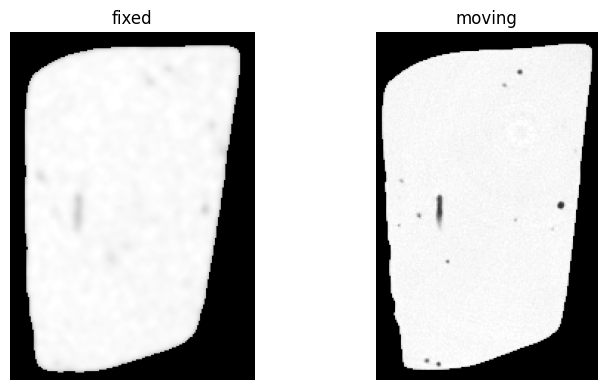

In [3]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)


gui.MultiImageDisplay(
    image_list=[fixed_image, moving_image],
    title_list=["fixed", "moving"],
    figure_size=(8, 4),
);

In [4]:
# this is the patching volume for non-rigid moving
[8] *moving_image.GetDimension()

[8, 8, 8]

In [7]:


def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f}"
    )


def registration_1(fixed, moving, mask):

    transformDomainMeshSize = [8] * moving.GetDimension()
    tx = sitk.BSplineTransformInitializer(fixed, transformDomainMeshSize)

    print("Initial Parameters:")
    #print(tx.GetParameters())

    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsCorrelation()

    R.SetOptimizerAsLBFGSB(
        gradientConvergenceTolerance=1e-5,
        numberOfIterations=100,
        maximumNumberOfCorrections=5,
        maximumNumberOfFunctionEvaluations=1000,
        costFunctionConvergenceFactor=1e7,
    )
    R.SetInitialTransform(tx, True)
    R.SetInterpolator(sitk.sitkLinear)

    R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
    
    
    # Connect all of the observers so that we can perform plotting during registration.
    R.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
    R.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
    R.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations)
    R.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(R))
    


    outTx = R.Execute(fixed, moving)

    print("-------")
    print(outTx)
    print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
    print(f" Iteration: {R.GetOptimizerIteration()}")
    print(f" Metric value: {R.GetMetricValue()}")

    #sitk.WriteTransform(outTx,"output/TransformationMatrix_001.tfm")

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)

    return_images = sitk.Resample(moving,fixed,outTx,sitk.sitkLinear,0.0,moving.GetPixelID(),)
    return_mask = sitk.Resample(mask,fixed,outTx,sitk.sitkLinear,0.0,mask.GetPixelID(),)

    return return_images, return_mask



Initial Parameters:


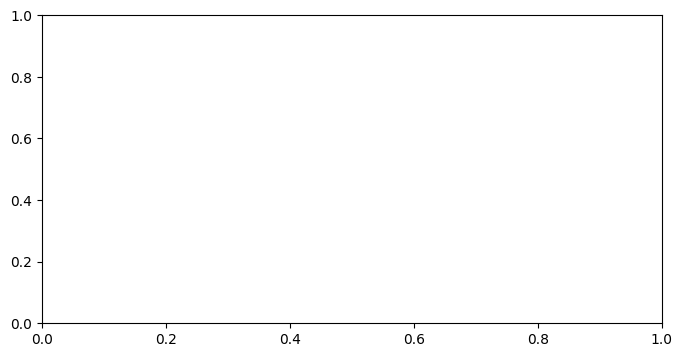

  0 =   -0.79193
  0 =   -0.79704
  0 =   -0.81495
  0 =   -0.85954
  0 =   -0.85954
  1 =   -0.66832
  1 =   -0.92822
  1 =   -0.92822
  2 =   -0.95216
  2 =   -0.95216
  3 =   -0.96127
  3 =   -0.96127
  4 =   -0.96534
  4 =   -0.96534
  5 =   -0.96736
  5 =   -0.96736
  6 =   -0.96924
  6 =   -0.96924
  7 =   -0.97043
  7 =   -0.97043
  8 =   -0.97155
  8 =   -0.97155
  9 =   -0.97225
  9 =   -0.97225
 10 =   -0.97297
 10 =   -0.97297
 11 =   -0.97383
 11 =   -0.97383
 12 =   -0.97431
 12 =   -0.97431
 13 =   -0.97517
 13 =   -0.97517
 14 =   -0.97579
 14 =   -0.97579
 15 =   -0.97649
 15 =   -0.97649
 16 =   -0.97649
 16 =   -0.97665
 16 =   -0.97665
 17 =   -0.97734
 17 =   -0.97734
 18 =   -0.97643
 18 =   -0.97734
 18 =   -0.97734
 19 =   -0.97747
 19 =   -0.97747
 20 =   -0.97778
 20 =   -0.97778
 21 =   -0.97755
 21 =   -0.97788
 21 =   -0.97788


In [ ]:
reg_image, return_masks = registration_1(fixed_image, moving_image, masks)

In [109]:
# Transforming the mask via mapping function
mask_array = sitk.GetArrayViewFromImage(return_masks)
mask = np.zeros_like(mask_array)
mask[mask_array>=0.5] = 1
mask[mask_array<0.5] = 0
mask.shape

(126, 235, 165)

In [103]:
# Transforming the high-res image via mapping function

high_res_array = sitk.GetArrayViewFromImage(reg_image)
high_res_array.shape

(126, 235, 165)

In [104]:
low_res_corresponding_array = sitk.GetArrayViewFromImage(fixed_image)
low_res_corresponding_array.shape

(126, 235, 165)

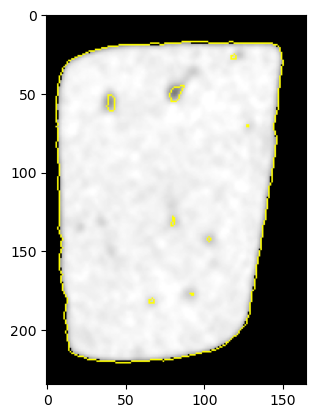

In [110]:
n=16
color_image = cv2.cvtColor(low_res_corresponding_array[n].astype('uint8'), cv2.COLOR_GRAY2BGR)
plt.imshow(skimage.segmentation.mark_boundaries(color_image,mask[n].astype('uint8')))

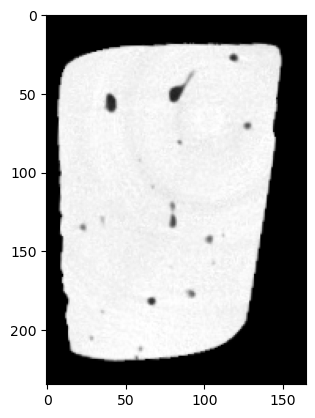

In [111]:
plt.imshow(high_res_array[n],'gray')

In [116]:
tifffile.imwrite('output/registered_mask.tif', mask[3:,:,:])
tifffile.imwrite('output/registered_high_res.tif',high_res_array[3:,:,:])
tifffile.imwrite('output/fixed_low_res.tif',low_res_corresponding_array[3:,:,:])